Initiation à Pytorch : Multilayer perceptron
============================

La plupart de ces notebooks peuvent tourner sans acceleration GPU. Vous pouvez utiliser Google Colab ou installer jupyter-notebook sur votre ordinateur. Pytorch est déjà installé sur Colab, par contre il faut suivre https://pytorch.org/get-started/locally/ en local.


In [4]:
## example de deployment local
# virtualenv -ppython3.7 pstaln-env
# . pstaln-env/bin/activate
# pip install torch==1.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# pip install matplotlib ipykernel
# python -m ipykernel install --user --name=pstaln-env
# jupyter-notebook
## puis sélectionner le noyeau pstaln-evn

On commence par importer les sous-modules de pytorch.
- `torch` rassemble les fonctions de création de tenseurs et les opérations sur les tenseurs
- `torch.nn` rassemble les couches de réseau de neurones
- `torch.nn.functional` rassemble une version sans état des couches de NN utilisable comme des fonctions
- `torch.optim` contient les optimiseurs pour l'apprentissage
- `torch.autograd` contient le moteur de calcul automatique de gradient, et en particulier la classe `Variable` que l'on doit utiliser pour décorer tous les tenseurs impliqués dans un calcul nécessitant un gradient

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Nous allons générer des points dans le plan dans l'intervalle $[-1.5, 1.5]\times[-1.5,1.5]$.

La fonction `torch.rand()` renvoie un tenseur de taille les dimensions passées en paramètres, contenant des nombres aléatoires entre 0 et 1.

Comme dans numpy, `X[:10]` renvoie les 10 premières lignes du tenseur. Il existe d'autres operations pour récupérer des sous-tenseurs, ou des scalaires.

In [2]:
n = 1000
X = torch.rand(n, 2) * 3 - 1.5

print(X[:10]) # 10 elements
print(X[0]) # first row
print(X[:,0]) # first column
print(X[0,1]) # element at a given location

tensor([[ 0.8426,  0.2601],
        [ 0.2081,  0.4409],
        [ 0.8510,  0.3120],
        [ 1.3732, -1.2364],
        [-0.2190, -0.2752],
        [ 0.2264, -1.4539],
        [ 1.2225,  0.4650],
        [ 1.4534,  0.6679],
        [ 1.4875, -1.4550],
        [ 0.4825,  1.0112]])
tensor([0.8426, 0.2601])
tensor([ 8.4258e-01,  2.0813e-01,  8.5097e-01,  1.3732e+00, -2.1898e-01,
         2.2638e-01,  1.2225e+00,  1.4534e+00,  1.4875e+00,  4.8247e-01,
        -2.6405e-03, -1.1967e+00,  7.8714e-01,  8.0597e-01,  2.3204e-01,
        -1.0467e+00,  6.8929e-01, -2.5929e-01, -4.6229e-01, -1.3120e+00,
         9.3351e-01,  2.4265e-01,  4.5921e-01,  1.0655e+00, -3.2272e-01,
        -7.1672e-01, -6.8654e-01, -2.6475e-01,  4.4117e-03, -6.6927e-01,
         1.1150e+00, -3.6919e-02,  1.3163e+00, -3.3220e-01, -3.9118e-02,
         1.0611e+00, -6.2036e-01,  6.9977e-01,  2.3592e-01, -7.9263e-01,
         1.3236e+00, -8.3890e-01, -7.5388e-01,  4.0081e-01, -2.1216e-01,
         1.8027e-01, -7.5180e-01, -7.

`X.size()` ou `X.shape` renvoie les dimensions d'un tenseur

In [3]:
print(X.size())
print(X.size(1))
print(X.shape)
print(X.shape[1])

torch.Size([1000, 2])
2
torch.Size([1000, 2])
2


Le problème que nous souhaitons résoudre est un problème simple : un point est-il dans le disque centré sur l'origine, de rayon 1 ?

Un exemple $x$ aura pour étiquette 1 si $x_0^2 + x_1^2 < 1$, 0 sinon.

Nous créons donc un tenseur `Y` contenant ces étiquettes. Comme une condition sur un tenseur renvoie un tenseur de type `ByteTensor`, nous devons le convertir en `LongTensor` qui est la représentation de base des étiquettes dans pytorch.

In [4]:
Y = X[:,0] ** 2 + X[:,1] ** 2 < 1
Y = Y.long()
Y[:10]

tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 0])

On peut ensuite afficher le résultat avec matplotlib. `plt.scatter` prend pour arguments un vecteur d'abscices (la première colonne de X), un vecteur d'ordonnées (la 2ième colonne de X) et un vecteur de valeurs pour les couleurs.

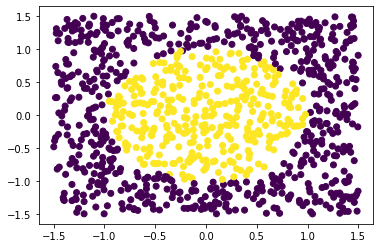

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

Nous allons maintenant entraîner un modèle linéaire à résoudre ce problème. Pour celà, nous devons étendre la classe `nn.Module`. Ce modèle contient une couche linéaire (`nn.Linear`) qui fait une transformation affine de ses entrées:

$y = W x + b$

Les deux paramètres du constructeur de `nn.Linear` sont le nombre la dimension d'un vecteur d'entrée (2 dans le plan) et la dimension du vecteur de sortie (2 étiquettes possibles). Celui-ci s'occupe d'initialiser les poids du réseau `W` et `b` de manière aléatoire.

Notre classe doit appeler le constructeur de sa classe mère pour fonctionner. Elle a une fonction `forward` qui est appelée lorsque l'on veut calculer la sortie du réseau pour une instance donnée.

In [6]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 2)
    def forward(self, x):
        return self.l1(x)

# dans ce cas, model = nn.Linear(2, 2) est identique à notre modèle
model = LinearModel()
model

LinearModel(
  (l1): Linear(in_features=2, out_features=2, bias=True)
)

Une fois un modèle instancié, on peut l'appeler sur un exemple sans passer directement par `forward`. Il est indispensable d'inclure le tenseur d'entrée dans une `Variable`. C'est cette class qui s'occupe de tracer les opérations executées pour pouvoir ensuite calculer automatiquement le gradient.

Le résultat est une transformation aléatoire de l'entrée, puis les paramètres de la couche ont été initialisés aléatoirement.

In [7]:
model(X[0])

tensor([0.5681, 0.2359], grad_fn=<AddBackward0>)

On peut facilement récupérer la valeur des paramètres du modèle.

In [8]:
print(model.l1.weight)
print(model.l1.bias)

Parameter containing:
tensor([[ 0.5328, -0.5787],
        [-0.6659,  0.3654]], requires_grad=True)
Parameter containing:
tensor([0.2697, 0.7019], requires_grad=True)


Il est important qu'un modèle puisse traiter plusieurs exemples à la fois. On parle de batch. Un batch est un tenseur regroupant plusieurs exemples qui seront traités en parallèle par les différentes opérations matricielles. Les batches sont indispensables pour la vitesse d'exécution mais aussi parce qu'ils permettent de régulariser l'optimisation du gradient (on optimise la fonction en direction du gradient moyen d'un batch).

Par convention, la première dimension d'un tenseur est la taille du batch.

In [9]:
print(X[:3])
model(X[:3])

tensor([[0.8426, 0.2601],
        [0.2081, 0.4409],
        [0.8510, 0.3120]])


tensor([[0.5681, 0.2359],
        [0.1254, 0.7245],
        [0.5425, 0.2493]], grad_fn=<AddmmBackward>)

Pour l'entrainement, nous allons devoir parcourir les données d'entraînement batch par batch, en mélangeant les exemples à chaque époque. Pytorch offre des classes qui font ce travail et gèrent le cas relativement facile où toutes les données d'entraînement sont dans un tenseur. Il existe d'autres cas où le chargement des données est moins simple. 

In [10]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X, Y)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

Nous allons créer une fonction qui entraîne un modèle par descente de gradient.

Cette fonction repose sur une fonction de coût ainsi qu'un algorithme d'optimisation. Pour la fonction de coût, nous utiliserons `CrossEntropyLoss` qui calcule l'entropie croisée entre la distribution produite par le système et les étiquettes de référence. Dans pytorch, cette fonction inclut le `softmax` qui s'assure que les scores soient entre 0 et 1, donc il faut bien éviter de l'appeler en fin d'inférence dans le modèle. Nous utiliserons ici l'optimiseur `Adam` qui converge plus rapidement que `SGD` (le gradient stochastique classique) grâce à un learning rate adaptatif. Son seul désavantage est qu'il utilise plus de mémoire ce qui peut poser problème sur GPU. 

La boucle d'entrainement fait plusieurs époques (passages sur toutes les données), où l'on parcourt les données batch par batch (ce que fait le `trainloader`).

Pour chaque batch, il faut remettre à zéro l'accumulateur de gradient, calculer les sorties du modèles, puis la fonction de loss entre les scores prédits et les étiquettes de référence.

On appelle `loss.backward()` pour calculer le gradient par back-propagation et `optimizer.step()` pour appliquer le gradient au modèle.

In [11]:
def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        total_loss = 0
        num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        if epoch % (epochs // 10) == 0:
            print(epoch, total_loss / num)

Nous pouvons entraîner le modèle sur 10 époques.

In [12]:
fit(model, 50)

0 0.21976653388142586
5 0.16380948713421822
10 0.16219189324975014
15 0.1621492102444172
20 0.16214232861995698
25 0.16214983037114145
30 0.16217244392633437
35 0.1621537845134735
40 0.16217750176787377
45 0.1621860966682434


On observe que le loss moyen sur les données d'entraînement descend mais converge très vite.

On peut maintenant produire un ensemble de validation indépendent `X_val` et générer les scores du modèle. La décision de ce modèle est l'étiquette pour laquelle ce score est maximal. La fonction `torch.max`, appliquée sur les lignes de la matrice `X_score`, renoie deux éléments : le vecteur des maximums, et le vecteur de indices des maximums. C'est ce dernier qui nous intéresse et que nous allons afficher.

Il est possible que le classifieur produise toujours la même étiquette, ce qui se traduit par une couleur de points uniformes. Sinon, l'espace doit être divisé en deux par le separateur linéaire appris par le modèle. Clairement, un modèle linéaire n'est pas capable de discriminer les points à l'interieur d'un cercle. 

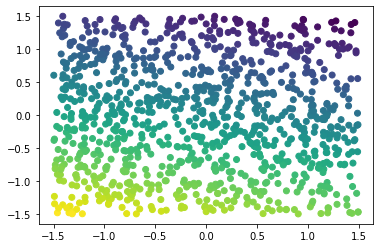

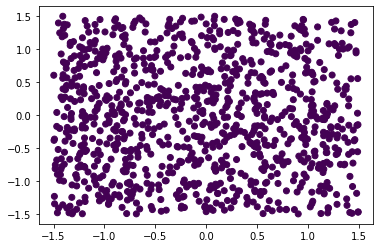

In [13]:
X_val = torch.rand(n, 2) * 3 - 1.5
Y_score = model(X_val)
Y_pred = torch.max(Y_score, 1)[1]

plt.scatter(X_val[:,0], X_val[:,1], c=Y_score[:,0].data)
plt.show()

plt.scatter(X_val[:,0], X_val[:,1], c=Y_pred.data)
plt.show()

Afin d'obtenir un meilleur classifieur, nous allons maintenant faire un perceptron multicouches (MLP) avec une fonction d'activation non linéaire.

$y = W_2 tanh(W_1 x + b_1) + b_2$

Ce modèle a deux couches linéaires, la première projetant les entrées dans un espace de 10 dimensions. Elle est suivie d'une fonction d'activation $tanh$ pour rendre le modèle non linéaire (la composition de fonctions linéaires serait elle même linéaire), et d'une seconde projection dans un espace de 2 dimensions pour les deux étiquettes à prédire.

In [14]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 2)
    def forward(self, x):
        return self.l2(torch.tanh(self.l1(x)))

mlp = MultiLayerPerceptron()
mlp

MultiLayerPerceptron(
  (l1): Linear(in_features=2, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=2, bias=True)
)

On peut alors entraîner ce modèle, et le loss baisse considérablement plus vite.

In [15]:
fit(mlp, 50)

0 0.16518076825141906
5 0.1556770578622818
10 0.13025894141197206
15 0.10112768994271755
20 0.07919413618743419
25 0.06486996646970511
30 0.055401517175138
35 0.04850064714811742
40 0.04355752290785313
45 0.03975653626769781


De la même manière, on peut produire les scores et les décisions pour le même ensemble de validation. La surface de décision produite est beaucoup plus pertinente. 

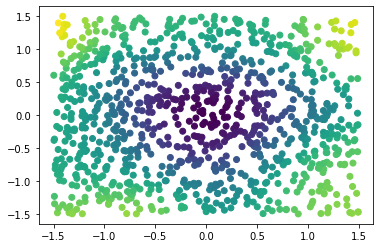

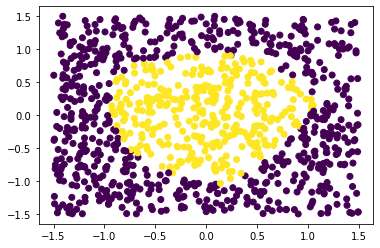

In [16]:
Y_score = mlp(X_val)
Y_pred = torch.max(Y_score, 1)[1]

plt.scatter(X_val[:,0], X_val[:,1], c=Y_score[:,0].data)
plt.show()

plt.scatter(X_val[:,0], X_val[:,1], c=Y_pred.data)
plt.show()

Exercice
---------

Prenons un problème plus difficile: les points à reconnaître appartiennent maintenant à deux cercles séparés dans le plan :
$
y = (2 x_0 - \frac{3}{2})^2 + x_1^2 < \frac{1}{2} \vee (2 x_0 + \frac{3}{2})^2 + x_1^2 < \frac{1}{2}
$

Le MLP à deux couches est-il capable de résoudre ce problème ? Qu'en serait-il d'un MLP à trois couches ? Et que se passe-t-il si on change la fonction d'activation pour utiliser des ReLU (`F.relu` dans pytorch) ?

Voici le travail à effectuer (à titre indicatif) :
1. générer des étiquettes $Y$ pour $X$ selon l'équation donnée ci-dessus (l'opérateur $\vee$ signifie un "ou" logique entre ses arguments, et peut être appliqué à deux matrices booléennes grâce à l'opérateur `|`), afficher ces nouvelles étiquettes
2. recréer un `DataLoader` à partir des nouvelles données
3. réinstancier un MLP et l'entraîner sur ces données
4. afficher la surface de décision correspondante
5. créer une nouvelle classe de modèle avec une couche supplémentaire et la tester
6. remplacer la fonction d'activation `F.tanh` par `F.relu`